In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0t9y43m9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0t9y43m9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
import clip
from PIL import Image
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [3]:
# Mount Google Drive
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/processed_dataset /content/dataset
!cp -r /content/drive/MyDrive/processed_test.zip /content/
!cp -r /content/drive/MyDrive/val_indices.json /content/
!cp -r /content/drive/MyDrive/train_indices.json /content/

with zipfile.ZipFile("/content/processed_test.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/test")

Mounted at /content/drive


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import cv2
def get_random_point_inside_object(mask):
    if mask is None:
        raise ValueError("Error: Mask is None")

    # Convert to uint8 if needed
    mask = mask.astype(np.uint8)

    # Binarize: foreground is any non-zero class
    _, mask_bin = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

    # Find contours of objects
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    # Create filled object mask
    object_mask = np.zeros_like(mask_bin)
    cv2.drawContours(object_mask, contours, -1, 255, thickness=cv2.FILLED)

    # Get interior pixels
    y_indices, x_indices = np.where(object_mask > 0)
    if len(y_indices) == 0:
        return None

    idx = np.random.randint(len(y_indices))
    return int(x_indices[idx]), int(y_indices[idx])

def generate_points_from_masks(masks):
    points = []
    for mask in masks.cpu().numpy():
        pt = get_random_point_inside_object(mask)
        if pt is not None:
            x, y = pt
            h, w = mask.shape
            # Normalize
            x_norm = x / w
            y_norm = y / h
            points.append((x_norm, y_norm))
        else:
            # Fallback to center point if no object found
            points.append((0.5, 0.5))
    return points

In [6]:
def create_gaussian_heatmap(mask_shape, point, sigma=10):

    x, y = point
    height, width = mask_shape

    # Create a grid of coordinates
    y_grid, x_grid = np.mgrid[0:height, 0:width]

    # Compute the Gaussian
    heatmap = np.exp(-((x_grid - x) ** 2 + (y_grid - y) ** 2) / (2 * sigma ** 2))

    #normalize heatmap
    if heatmap.max() > 0:
      heatmap = heatmap / heatmap.max()
    else:
      heatmap = np.zeros_like(heatmap)

    # Convert to a PyTorch tensor
    heatmap_tensor = torch.tensor(heatmap, dtype=torch.float32)

    return heatmap_tensor

def append_heatmap_to_tensor(input_tensor, heatmap_tensor):

    # Ensure the heatmap tensor has the same spatial dimensions as the input tensor
    if input_tensor.shape[1:] != heatmap_tensor.shape:
        raise ValueError("Heatmap and input tensor must have the same spatial dimensions.")

    # Add a channel dimension to the heatmap
    heatmap_tensor = heatmap_tensor.unsqueeze(0)  # Shape: (1, H, W)

    # Concatenate the heatmap with the input tensor along the channel dimension
    combined_tensor = torch.cat([input_tensor, heatmap_tensor], dim=0)  # Shape: (C + 1, H, W)

    return combined_tensor

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, csv_path, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transforms.ToTensor() if transform is None else transform
        self.class_labels = pd.read_csv(csv_path)

        self.images = []
        for img in os.listdir(image_dir):
            if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                self.images.append(os.path.join(image_dir, img))
        self.images.sort()

        self.masks = sorted([mask for mask in os.listdir(mask_dir) if mask.lower().endswith('.png')])

        self.matched_pairs = []
        mask_basenames = {os.path.splitext(os.path.basename(mask))[0]: mask for mask in self.masks}

        for img_path in self.images:
            img_basename = os.path.splitext(os.path.basename(img_path))[0]
            if img_basename in mask_basenames:
                self.matched_pairs.append((img_path, mask_basenames[img_basename]))

        if len(self.matched_pairs) == 0:
            raise ValueError(f"No matching image-mask pairs found. Check that filenames match between directories.")

        print(f"Found {len(self.matched_pairs)} matched image-mask pairs in {image_dir} and {mask_dir}")

        try:
            self.clip_model, self.preprocess = clip.load("ViT-L/14", device=device)
            self.clip_model.eval()
        except Exception as e:
            print(f"Error loading CLIP model: {e}")
            raise

    def __len__(self):
        return len(self.matched_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.matched_pairs[idx]
        mask_path = os.path.join(self.mask_dir, mask_path)
        img_filename = os.path.basename(img_path)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Get class label from CSV
        labels = self.class_labels.loc[self.class_labels['filename'] == img_filename, 'label'].values
        class_label = labels[0] if len(labels) > 0 else 0

        mask = np.array(mask, dtype=np.uint8)
        mask[mask != 0] = class_label
        mask = torch.tensor(mask, dtype=torch.long)

        # Process image for CLIP
        clip_input = self.transform(image).float()

        # Get original image dimensions for resizing later
        original_size = image.size

        return clip_input, mask, original_size, img_filename

In [8]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),    # 224 → 112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 112 → 56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 56 → 28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 28 → 14
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # 14 → 14
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1), # 14 → 28
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1), # 28 → 14
            nn.ReLU(),
            nn.Upsample(size=(16,16), mode='bilinear', align_corners=False) # exactly 16x16
        )

    def forward(self, x):
        return self.encoder(x)  # [B, 512, 16, 16]


In [9]:
class UNetDecoder(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1537, 512, kernel_size=4, stride=2, padding=1),  # now matches input!
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1),
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
        )



    def forward(self, x):
        return self.decoder(x)

In [10]:
def get_clip_embedding(x, clip_model):
    with torch.no_grad():
        emb = clip_model.encode_image(x).float()  # [B, 512]
        emb = emb[:, :, None, None]  # reshape to [B, 512, 1, 1]
        emb = emb.repeat(1, 1, 7, 7)  # broadcast to spatial dimensions [B, 512, 7, 7]
    return emb

In [11]:

class CLIPSegmentationModel(nn.Module):
    def __init__(self, clip_model, num_classes=3):
        super().__init__()
        self.cnn_encoder = CNNEncoder()
        self.clip_model = clip_model
        self.decoder = UNetDecoder(num_classes)
        self.clip_model = clip_model.float()


        self.clip_dtype = self.clip_model.visual.conv1.weight.dtype

        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # Extract feature dimensions from CLIP
        self.feature_dim = self.clip_model.visual.output_dim  # 512 for ViT-B/32

        # Text embeddings for classes
        self.register_text_embeddings()

    def register_text_embeddings(self):
        # Create text embeddings for our classes
        text_inputs = torch.cat([
            clip.tokenize("a background"),
            clip.tokenize("a cat"),
            clip.tokenize("a dog")
        ]).to(device)

        with torch.no_grad():
            self.text_features = self.clip_model.encode_text(text_inputs)
            self.text_features = F.normalize(self.text_features, dim=1)

        # Save text features as a buffer
        self.register_buffer("class_embeddings", self.text_features)

    def forward(self, images, points=None):
        # CNN Encoder (float32)
        cnn_features = self.cnn_encoder(images)  # [B,1024,16,16], float32

        # CLIP Encoder
        clip_images = images.to(self.clip_dtype)
        with torch.no_grad():
            x = self.clip_model.visual.conv1(clip_images)
            x = x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)

            cls_emb = self.clip_model.visual.class_embedding
            cls_emb = cls_emb + torch.zeros(x.shape[0], 1, x.shape[-1], device=x.device, dtype=cls_emb.dtype)

            x = torch.cat([cls_emb, x], dim=1)
            x = x + self.clip_model.visual.positional_embedding
            x = self.clip_model.visual.ln_pre(x)

            x = x.permute(1, 0, 2)
            x = self.clip_model.visual.transformer(x)
            x = x.permute(1, 0, 2)

            spatial_features = x[:, 1:, :]
            spatial_features = spatial_features.permute(0, 2, 1).reshape(-1, 1024, 16, 16)
            spatial_features = spatial_features.float()

        # Combine CNN + CLIP features
        combined_features = torch.cat([cnn_features, spatial_features], dim=1)  # [B,2048,16,16]

        # === POINT HEATMAP FUSION ===
        if points is not None:
            B, _, H, W = combined_features.shape
            heatmaps = []

            for i in range(B):
                if points[i] is not None:
                    x_norm, y_norm = points[i]  # normalized coords (0-1)
                    px = int(x_norm * W)
                    py = int(y_norm * H)
                    heatmap = create_gaussian_heatmap((H, W), (px, py), sigma=2.5)  # sigma ~2-3 works well for 16x16
                else:
                    heatmap = torch.zeros((H, W), dtype=torch.float32)

                heatmaps.append(heatmap)

            # Stack and move to same device
            heatmaps = torch.stack(heatmaps, dim=0).unsqueeze(1).to(combined_features.device)  # [B,1,H,W]

            # Concatenate point heatmaps as an extra channel
            combined_features = torch.cat([combined_features, heatmaps], dim=1)  # Now [B,2049,16,16]

        # Decode
        segmentation_mask = self.decoder(combined_features)

        return segmentation_mask


In [12]:
def train_model(model, train_loader, val_loader, num_epochs=15, lr=1e-4):
    class_weights = torch.tensor([0.8, 1.5, 1.2]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'val_iou': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        #pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, masks, _, _ in train_loader:
            images = images.float().to(device)
            masks = masks.to(device)

            # Forward pass
            points = generate_points_from_masks(masks)
            outputs = model(images, points=points)
            loss = criterion(outputs, masks)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            #pbar.set_postfix({'loss': loss.item()})

        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Validation
        val_loss, val_iou = evaluate_model(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')

        # Learning rate scheduler
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_clip_segmentation_model.pth')
            print("Saved best model checkpoint")

    # Plot training history
    #plot_training_history(history)

    return model, history

In [13]:
def evaluate_model(model, dataloader, criterion=None):
    model.eval()
    val_loss = 0.0
    class_stats = {i: {"intersection": 0, "union": 0} for i in range(3)}

    with torch.no_grad():
        for images, masks, _, _ in dataloader:
            images = images.float().to(device)
            masks = masks.to(device)

            points = generate_points_from_masks(masks)
            outputs = model(images, points=points)

            if criterion:
                loss = criterion(outputs, masks)
                val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).to(device)

            # Calculate IoU directly on GPU
            for class_idx in range(3):
                class_mask = (masks == class_idx)
                class_pred = (preds == class_idx)

                # Calculate intersection and union directly on the GPU
                intersection = torch.logical_and(class_mask, class_pred).sum().item()
                union = torch.logical_or(class_mask, class_pred).sum().item()

                class_stats[class_idx]["intersection"] += intersection
                class_stats[class_idx]["union"] += union

    # Calculate IoU scores
    iou_scores = []
    for class_idx in range(3):
        intersection = class_stats[class_idx]["intersection"]
        union = class_stats[class_idx]["union"]
        iou = intersection / union if union > 0 else 0.0
        iou_scores.append(iou)

    mean_iou = np.mean(iou_scores)

    if criterion:
        val_loss /= len(dataloader)
        return val_loss, mean_iou
    else:
        return mean_iou



In [14]:
image_dir = "/content/dataset/color/"
mask_dir = "/content/dataset/label/"
csv_path = "/content/dataset/labels.csv"
# Create datasets and dataloaders

# Create train/val/test splits (assuming 70/15/15 split)
dataset = SegmentationDataset(image_dir, mask_dir, csv_path)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset, = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)


batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create and train
clip_model, _ = clip.load("ViT-L/14", device=device)

model = CLIPSegmentationModel(clip_model).to(device)
model, history = train_model(model, train_loader, val_loader, num_epochs=20)

# Evaluate on test set

# Visualize some results
#visualize_predictions(model, test_loader)

Found 3680 matched image-mask pairs in /content/dataset/color/ and /content/dataset/label/


100%|███████████████████████████████████████| 890M/890M [00:23<00:00, 39.3MiB/s]


Epoch 1/20, Train Loss: 0.2843, Val Loss: 0.1170, Val IoU: 0.8919
Saved best model checkpoint
Epoch 2/20, Train Loss: 0.1097, Val Loss: 0.1060, Val IoU: 0.8987
Saved best model checkpoint
Epoch 3/20, Train Loss: 0.0994, Val Loss: 0.1200, Val IoU: 0.8972
Epoch 4/20, Train Loss: 0.0907, Val Loss: 0.0987, Val IoU: 0.9028
Saved best model checkpoint
Epoch 5/20, Train Loss: 0.0832, Val Loss: 0.0969, Val IoU: 0.9094
Saved best model checkpoint
Epoch 6/20, Train Loss: 0.0752, Val Loss: 0.1001, Val IoU: 0.9014
Epoch 7/20, Train Loss: 0.0666, Val Loss: 0.1020, Val IoU: 0.9074
Epoch 8/20, Train Loss: 0.0583, Val Loss: 0.1023, Val IoU: 0.9043
Epoch 9/20, Train Loss: 0.0456, Val Loss: 0.1145, Val IoU: 0.9130
Epoch 10/20, Train Loss: 0.0387, Val Loss: 0.1209, Val IoU: 0.9120
Epoch 11/20, Train Loss: 0.0333, Val Loss: 0.1330, Val IoU: 0.9116
Epoch 12/20, Train Loss: 0.0268, Val Loss: 0.1470, Val IoU: 0.9121
Epoch 13/20, Train Loss: 0.0232, Val Loss: 0.1610, Val IoU: 0.9116
Epoch 14/20, Train Loss: 0

KeyboardInterrupt: 

In [15]:
import gc

torch.cuda.empty_cache()
gc.collect()

# Load CLIP model to GPU
clip_model, _ = clip.load("ViT-L/14", device=device)

# Load your custom model and move it to the GPU
model = CLIPSegmentationModel(clip_model).to(device)

# Load model weights (move weights to the correct device)
model.load_state_dict(torch.load("best_clip_segmentation_model.pth", map_location=device))

# Setup batch size and DataLoader
batch_size = 4
image_test_dir = "/content/test/processed_test/color/"
mask_test_dir = "/content/test/processed_test/label/"
csv_test_path = "/content/test/processed_test/labels.csv"

test_dataset = SegmentationDataset(image_test_dir, mask_test_dir, csv_test_path)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test set (move inputs to GPU)
test_iou = evaluate_model(model, test_loader)
print(f"Test IoU: {test_iou:.4f}")

Found 3710 matched image-mask pairs in /content/test/processed_test/color/ and /content/test/processed_test/label/
Test IoU: 0.9094


In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_iou'], label='Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

In [ ]:
def predict_image(model, image_path):
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.ToTensor()
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1)[0].cpu().numpy()

    # Visualize result
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    class_colors = {0: [0, 0, 0], 1: [1, 0, 0], 2: [0, 0, 1]}  # Background: black, Cat: red, Dog: blue
    pred_colored = np.zeros((pred.shape[0], pred.shape[1], 3))
    for cls in range(3):
        pred_colored[pred == cls] = class_colors[cls]

    plt.subplot(1, 2, 2)
    plt.imshow(pred_colored)
    plt.title('Segmentation Result')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_result.png')
    plt.show()

    return pred

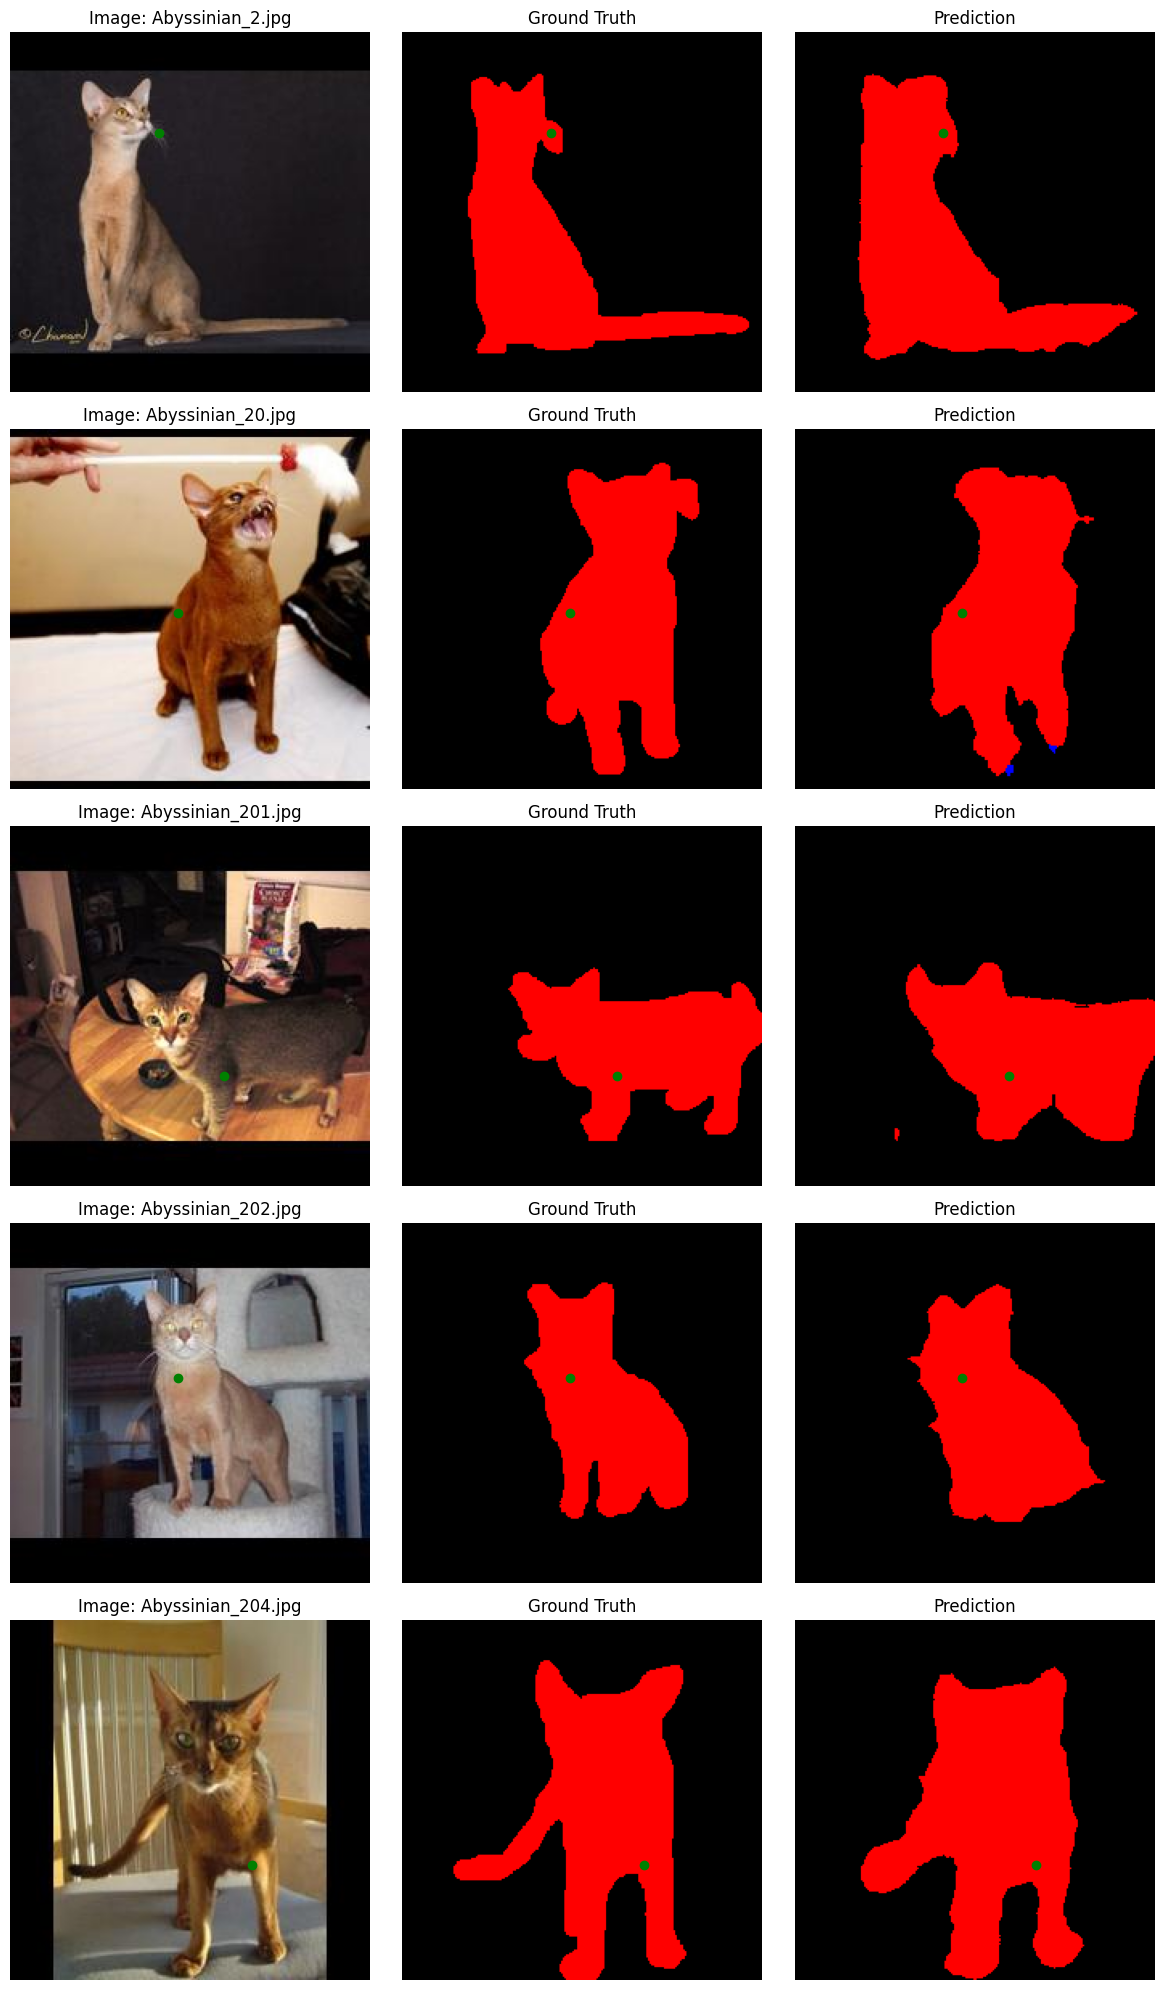

In [16]:
num_samples=5
model.eval()

samples = []
with torch.no_grad():
    for images, masks, _, filenames in test_loader:
        if len(samples) >= num_samples:
            break

        images = images.to(device)
        masks = masks
        points = generate_points_from_masks(masks)
        outputs = model(images, points=points)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        for i in range(images.shape[0]):
            if len(samples) < num_samples:
                samples.append((images[i].cpu(), masks[i], preds[i], filenames[i],points[i]))

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
class_colors = {0: [0, 0, 0], 1: [1, 0, 0], 2: [0, 0, 1]}  # Background: black, Cat: red, Dog: blue

for i, (image, mask, pred, filename,point) in enumerate(samples):
    x,y=point

    _, H, W = image.shape
    x= int(x * W)
    y= int(y * H)

    # Convert image from tensor [C,H,W] to numpy [H,W,C]
    img_np = image.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Create colored mask and prediction
    mask_colored = np.zeros((mask.shape[0], mask.shape[1], 3))
    pred_colored = np.zeros((pred.shape[0], pred.shape[1], 3))

    for cls in range(3):
        mask_colored[mask == cls] = class_colors[cls]
        pred_colored[pred == cls] = class_colors[cls]

    # Plot
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f"Image: {filename}")
    axes[i, 0].axis('off')
    axes[i, 0].plot(x,y,'go')

    axes[i, 1].imshow(mask_colored)
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis('off')
    axes[i, 1].plot(x,y,'go')

    axes[i, 2].imshow(pred_colored)
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis('off')
    axes[i, 2].plot(x,y,'go')

plt.tight_layout()
plt.savefig('segmentation_results.png')
plt.show()
plt.close()


In [17]:
import torch

def iou_per_class(y_true, y_pred, num_classes):
    iou_scores = []
    for cls in range(num_classes):
        intersection = torch.logical_and(y_true == cls, y_pred == cls).float().sum()
        union = torch.logical_or(y_true == cls, y_pred == cls).float().sum()
        iou_scores.append((intersection / union).item() if union > 0 else 0.0)
    return iou_scores  # List of IoU scores for each class

def dice_per_class(y_true, y_pred, num_classes):
    dice_scores = []
    for cls in range(num_classes):
        intersection = torch.logical_and(y_true == cls, y_pred == cls).float().sum()
        denominator = (y_true.eq(cls).float().sum() + y_pred.eq(cls).float().sum())
        dice_scores.append((2.0 * intersection / denominator).item() if denominator > 0 else 0.0)
    return dice_scores  # List of Dice scores for each class

def pixel_accuracy_per_class(y_true, y_pred, num_classes):
    acc_scores = []
    for cls in range(num_classes):
        mask_cls = (y_true == cls)
        acc_scores.append((y_pred[mask_cls] == cls).float().mean().item() if mask_cls.sum() > 0 else 0.0)
    return acc_scores  # List of Accuracy scores for each class

In [20]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def evaluate_model_per_class(model, test_loader, num_classes, device="cuda"):
    model.eval()
    iou_scores_per_class = [[] for _ in range(num_classes)]
    dice_scores_per_class = [[] for _ in range(num_classes)]
    accuracy_scores_per_class = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images, masks, _, _ in test_loader:
            images, masks = images.to(device), masks.to(device)
            points = generate_points_from_masks(masks)
            outputs = model(images, points=points)
            preds = torch.argmax(outputs, dim=1)  # Convert to class labels

            for i in range(len(images)):
                iou_scores = iou_per_class(masks[i], preds[i], num_classes)
                dice_scores = dice_per_class(masks[i], preds[i], num_classes)
                acc_scores = pixel_accuracy_per_class(masks[i], preds[i], num_classes)

                for cls in range(num_classes):
                    iou_scores_per_class[cls].append(iou_scores[cls])
                    dice_scores_per_class[cls].append(dice_scores[cls])
                    accuracy_scores_per_class[cls].append(acc_scores[cls])

    # Compute mean per-class metrics (handle empty lists)
    mean_iou_per_class = [torch.mean(torch.tensor(scores)).item() if scores else 0.0 for scores in iou_scores_per_class]
    mean_dice_per_class = [torch.mean(torch.tensor(scores)).item() if scores else 0.0 for scores in dice_scores_per_class]
    mean_accuracy_per_class = [torch.mean(torch.tensor(scores)).item() if scores else 0.0 for scores in accuracy_scores_per_class]

    # Compute overall mean (average over classes)
    mean_iou = sum(mean_iou_per_class) / num_classes
    mean_dice = sum(mean_dice_per_class) / num_classes
    mean_accuracy = sum(mean_accuracy_per_class) / num_classes

    print(f"Mean IoU Per Class: {mean_iou_per_class}")
    print(f"Mean Dice Per Class: {mean_dice_per_class}")
    print(f"Mean Accuracy Per Class: {mean_accuracy_per_class}")
    print(f"Overall Mean IoU: {mean_iou:.4f} (Baseline: 0.33)")
    print(f"Overall Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Overall Mean Pixel Accuracy: {mean_accuracy:.4f}")

    return mean_iou_per_class, mean_dice_per_class, mean_accuracy_per_class, mean_iou, mean_dice, mean_accuracy

In [21]:
#create test set and evaluate on it
num_classes = 3

evaluate_model_per_class(model,test_loader, num_classes)

Mean IoU Per Class: [0.9451179504394531, 0.2865263521671295, 0.5912129282951355]
Mean Dice Per Class: [0.9710943698883057, 0.3036676049232483, 0.6279258728027344]
Mean Accuracy Per Class: [0.9700397849082947, 0.30836957693099976, 0.629808247089386]
Overall Mean IoU: 0.6076 (Baseline: 0.33)
Overall Mean Dice Coefficient: 0.6342
Overall Mean Pixel Accuracy: 0.6361


([0.9451179504394531, 0.2865263521671295, 0.5912129282951355],
 [0.9710943698883057, 0.3036676049232483, 0.6279258728027344],
 [0.9700397849082947, 0.30836957693099976, 0.629808247089386],
 0.6076190769672394,
 0.6342292825380961,
 0.6360725363095602)